In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import quail
import pickle
import scipy
from scipy.stats import pearsonr
import pandas as pd
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from itertools import groupby
from matplotlib.patches import Ellipse

<h2> Import Data </h2>

In [2]:
#load in subject data
egg = pickle.load(open('../data/automatic_transcription.p', 'rb'))

In [3]:
#load data for subject lists and confidence scores
ROC_DATA = pickle.load(open('../data/formattedforROC.p', 'rb'))

In [4]:
ALL_WORDS_MAN = pickle.load(open('../data/ROC_manual_transcriptions.p', 'rb'))

In [5]:
#confirm number of subjects
len(ROC_DATA)/17

30

In [6]:
egg.meta['ids'].append(u'debugQVC5IH:debugWA2XJU')
egg.meta['ids'].append(u'debugZANF1E:debugNSAB89')
filenames = sorted(egg.meta['ids'])

<h2> Organize Auto words and conf ratings </h2>

In [8]:
#three lists

#subID - list of IDs in order
# word - nested lists [subject][list]
# conf - nested lists [subject][list]


IDs = range(0, 510, 17)

subID=[]
conf_list = []
word_list = []

#for each sub, get subID
for item in ROC_DATA:
    if ROC_DATA.index(item) in IDs:
        subID.append(item[-23:])
        
    #list words and confs
    else:
        word_list.append(item[0][0])
        conf_list.append(item[1][0])
#nest lists
word = [word_list[i:i+8] for i in range(0,len(word_list), 8)]
conf = [conf_list[i:i+8] for i in range(0,len(conf_list), 8)]

print subID

[u'debugMZNC0G:debugHH9F77', u'debugJKZ2FK:debug69AISL', u'debugXDG5RF:debugHHZWWB', u'debugYP8A2G:debug2FTXIJ', u'debugL2YZ74:debugXLYC15', u'debugGRV2XM:debugCBZLQI', u'debugU2BCQM:debugZV1XCV', u'debugEZ0I68:debug0BYRL0', u'debugB2KA2H:debugXQ3KDZ', u'debugBAYG6H:debugO6ZJRN', u'debugVEI69J:debug4S3C4D', u'debugQ9SHVQ:debug8PBYVB', u'debugOZAQYJ:debug6QIMBF', u'debug73JNQK:debugN2XGP7', u'debug4X4DE6:debugONBJTZ', u'debugNF909Z:debugRITT3W', u'debug63UEQR:debugAALQ9G', u'debugEY2LWF:debug1PMZR2', u'debugTPKLST:debug503VMS', u'debugRRBNAW:debugM9FO30', u'debugKU7RF0:debugRRRR00', u'debug9SX3WY:debug04DLKW', u'debug9ZTC3N:debugPE34MP', u'debugZ39CK8:debugGKMQ4X', u'debug7N3YDC:debugZU2H5M', u'debugF4JQ78:debugI90DQT', u'debug8NIU5A:debugJTGEJP', u'debugGPOMKR:debugO339U2', 'debugZANF1E:debugNSAB89', 'debugQVC5IH:debugWA2XJU']


In [9]:
#make everything all caps to match manual transcriptions
new_transcription_ROC = []
for subject in word:
    new_subject = []
    for lst in subject:
        new_lst = []
        for word in lst:
            new_lst.append(word.upper())
        new_subject.append(new_lst)
    new_transcription_ROC.append(new_subject)
    
word = new_transcription_ROC

In [10]:
del word[1::2]
del conf[1::2]

In [11]:
print len(word[0][0])
print len(conf[0][0])
print word[27][7]
print conf[0][0]

13
13
['FINGER', 'ANKLE', 'LIP', 'LARVA', 'SCORPION', 'MONARCH', 'BONGOS', 'ACCORDION', 'GUITAR', 'XYLOPHONE', 'WILLOW', 'EUCALYPTUS', 'POPLAR']
['0.849048554897', '0.889870762825', '0.768749892712', '0.891385734081', '0.875405490398', '0.811597287655', '0.909090936184', '0.848529279232', '0.804279625416', '0.809303343296', '0.801754236221', '0.521171867847', '0.899440169334']


<h2> Grab Words By Confidence Rating </h2>

In [12]:
#create dict that will have one list for every confidence rating
#CONF_DICT[CONF_x] = nested list [subject][trial[]]
CONF_DICT = {}
conf_rate = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for rate in conf_rate:
    CONF_DICT['CONF_%s' % str(rate)[2]] = []
    CONF_DICT['AVG_PER_LIST_%s' % str(rate)[2]] = []

# update dictionary for each confidence rating:
for rate in conf_rate:
    #loop over each subject and get all auto words that have that confidence rating
    for subject in word:
        #x is a list containing one list of words per trial for current subject
        x= [[]]
        x= [[] for n in range(8)]
        #(these are all unique lists that can be modified one at a time, before it was written so changing one changed them all)
        
        #for each word recalled, if conf>rate add it to x in the correct index for the trial 
        for lst in subject:
            for recall in lst:
                if float(conf[word.index(subject)][subject.index(lst)][lst.index(recall)]) > rate:
                    if recall[:1] == ' ':
                        x[subject.index(lst)].append(recall[1:])
                    else:
                        x[subject.index(lst)].append(recall)
        
        #once all words are appended to x in the right index, add x to correct list in the dictionary
        CONF_DICT['CONF_%s' % str(rate)[2]].append(x)

<h2> Get List of Words Auto in Man, Auto Not in Man for Each Confidence Rating </h2>

In [13]:
#add two lists to dictionary per confidence rating, auto in man and auto not in man
#these are nested lists of words [subject][trial[]] 
for rate in conf_rate:
    CONF_DICT['AUTO_IN_MAN_%s' % str(rate)[2]] = []
    CONF_DICT['AUTO_NOT_IN_MAN_%s' % str(rate)[2]] = []
    
#update dictionary for each confidence rating:
for rate in conf_rate:
    #loop over each subject for each confidence rating
    for subject in CONF_DICT['CONF_%s' % str(rate)[2]]:
    
        #in_man is a list containing one list (of words in auto also in man) per trial for current subject
        in_man = [[]]
        in_man = [[] for n in range(8)]
    
        #not_in is a list containing one list (of words in auto not also in man) per trial for current subject
        not_in = [[]]
        not_in = [[] for n in range(8)]

        
        for lst in subject:
            for recall in lst: 
                #get auto in man, auto not in man for each trial
                if recall in ALL_WORDS_MAN[CONF_DICT['CONF_%s' % str(rate)[2]].index(subject)][subject.index(lst)]:
                    in_man[subject.index(lst)].append(recall)
                else:
                    not_in[subject.index(lst)].append(recall)
    
        #update lists so there's one list per subject
        CONF_DICT['AUTO_IN_MAN_%s' % str(rate)[2]].append(in_man)
        CONF_DICT['AUTO_NOT_IN_MAN_%s' % str(rate)[2]].append(not_in)

<h2> Get Total Unique Words Between Auto and Man for Each Trial </h2>

In [14]:
#add one list to dictionary per confidence rating
#these are nested lists of total unique words for each trial [subject][trial[]] 
for rate in conf_rate:
    CONF_DICT['UNIQUE_%s' % str(rate)[2]] = []

sub_num = range(0, 28)
trial_num = range(0, 8)
for rate in conf_rate:  
    for subject in sub_num:
        #uniq is a list containing one list (of total unique words between auto and man) per trial for current subject
        uniq = []
        #uniq = [[] for n in range(8)]
        
        for trial in trial_num:
            #get total unique words for each trial
            auto_uniq = set(word[subject][trial])
            man_uniq = set(ALL_WORDS_MAN[subject][trial])
            uniq.append(list(auto_uniq.union(man_uniq)))
    
        CONF_DICT['UNIQUE_%s' % str(rate)[2]].append(uniq)

<h2> Calculate FPR and TPR for each list </h2>

In [15]:
#false positive rate = # words in auto not in man / # total unique words
#true positive rate = # words in auto that are in man / # total unique words

#add two list to dictionary per confidence rating, FPR and TPR
#these are nested lists of the proportions for each trial [subject][trial[]] 
for rate in conf_rate:
    CONF_DICT['FPR_%s' % str(rate)[2]] = []
    CONF_DICT['TPR_%s' % str(rate)[2]] = []

for rate in conf_rate:
    for subject in sub_num:
        #fpr is a list containing all FPR for that subject
        fpr = []
        fpr = [[] for n in range(8)]
        
        #tpr is a list containing all TPR for that subject
        tpr = []
        tpr = [[] for n in range(8)]
        
        for trial in trial_num:
            #if len(CONF_DICT['AUTO_IN_MAN_%s' % str(rate)[2]][subject][trial])>= 1:
            #get FPR and TPR for each trial
                tpr[trial] = (float(len(CONF_DICT['AUTO_IN_MAN_%s' % str(rate)[2]][subject][trial])))/(float(len(CONF_DICT['UNIQUE_%s' % str(rate)[2]][subject][trial])))

            #if len(CONF_DICT['AUTO_NOT_IN_MAN_%s' % str(rate)[2]][subject][trial])>= 1:
                fpr[trial] = (float(len(CONF_DICT['AUTO_NOT_IN_MAN_%s' % str(rate)[2]][subject][trial])))/(float(len(CONF_DICT['UNIQUE_%s' % str(rate)[2]][subject][trial])))

        
        CONF_DICT['FPR_%s' % str(rate)[2]].append(fpr)
        CONF_DICT['TPR_%s' % str(rate)[2]].append(tpr)

<h2> Get Average FPR and TPR for Each Subject </h2>

In [16]:
#these lists have one value for each subject in each confidence range (so 28*9 values total)
FPR = []
TPR = []

#add point (1,1)
FPR.append(1)
TPR.append(1)

#get x and y error bars
#x error = list of standard deviations for each fpr_byrate
x_errors = [np.float64(0.0)]
#y error = list of standard deviations for each tpr_byrate
y_errors = [np.float64(0.0)]

for rate in conf_rate:
    fpr_byrate = []
    tpr_byrate = []
    
    #looping over all subjects for current conf rating
    #
    for subject in sub_num:
        fpr_byrate.append(sum(CONF_DICT['FPR_%s' % str(rate)[2]][subject])/float(len(CONF_DICT['FPR_%s' % str(rate)[2]][subject])))
        tpr_byrate.append(sum(CONF_DICT['TPR_%s' % str(rate)[2]][subject])/float(len(CONF_DICT['TPR_%s' % str(rate)[2]][subject])))
    
    FPR.append(sum(fpr_byrate)/float(len(fpr_byrate)))
    TPR.append(sum(tpr_byrate)/float(len(tpr_byrate)))
    
    #add standard deviations to error barror lists
    
    
    x_errors.append(np.std(fpr_byrate))
    y_errors.append(np.std(tpr_byrate))
    
x_errors.append(np.float64(0.0))
y_errors.append(np.float64(0.0))

<h2> Plot ROC Curve </h2>

/Users/paxtonfitzpatrick/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


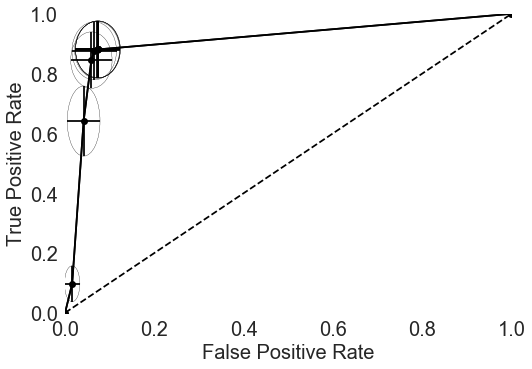

FPR =
[1, 0.07349944835467005, 0.07349944835467005, 0.07315604176126346, 0.07315604176126346, 0.07172845149438747, 0.06534497262206931, 0.05892441962522955, 0.04156161822553215, 0.015898247851925708, 0]
TPR =
[1, 0.8808425145530548, 0.8808425145530548, 0.8808425145530548, 0.8808425145530548, 0.879133360611758, 0.8762060678998013, 0.8451709338578396, 0.6413234824508874, 0.09727023457984596, 0]


In [17]:
#add point (0,0)
FPR.append(0)
TPR.append(0)

#plot
fig, ax = plt.subplots()
plt.plot(FPR, TPR, 'ko-')
    
#set x and y limits, label plot
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'k--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('True Positive Rate', size = 20)
plt.xlabel('False Positive Rate', size = 20)
ax.set_facecolor('white')
plt.tick_params(labelsize=20)


#error ellipses
ax.errorbar(FPR, TPR, xerr = x_errors, yerr = y_errors, color = 'k')
i =0
while i < 10:
    ax.add_artist(Ellipse(xy = (FPR[i], TPR[i]), width = 2*x_errors[i], height = 2*y_errors[i], edgecolor = 'k', facecolor='none'))
    i+=1

# #save plot and show
plt.savefig('ROC_curve.pdf')
plt.show() 

print 'FPR ='
print FPR
print 'TPR ='
print TPR

<h2> get area under curve </h2>

In [18]:
print auc(FPR, TPR)

0.9071437140720325
